<a href="https://colab.research.google.com/github/alirezash97/Convolutional-Neural-Network/blob/master/Statistical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install awscli
!pip install nilearn
!pip install nibabel
!aws s3 sync --no-sign-request s3://openneuro.org/ds001246 ds001246-download/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 23.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyYAML: filename=PyYAML-5.4.1-cp310-cp310-linux_x86_64.whl size=45658 sha256=2e2d0edb40c96c6b073784391cad684445a14cc564f0acf2ac4dd2f8a20c82fe
  Stored in directory: /root/.cache/pip/wheels/c7/0d/22/696ee92245ad710f506eee79bb05c740d8abccd3ecdb778683
Successfully built PyYAML
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting un

In [2]:
!mkdir ds001246-download/combined
!mkdir ds001246-download/combined/images
!mkdir ds001246-download/combined/events
!mkdir ds001246-download/resampled
!mkdir ds001246-download/modifiedtsv

# Prepare Data

In [3]:
import numpy as np
from nibabel import filebasedimages, save, Nifti1Image


In [4]:
from nilearn.image import load_img
from nibabel.funcs import concat_images

def combine_img(img, new_img):
  
    if img == None:
        combined_img = load_img(new_img)
    else:
        loaded_img = load_img(new_img)
        combined_img = concat_images([img, loaded_img], axis=-1, check_affines=False)

    return combined_img

In [5]:
import pandas as pd
from pandas import read_csv

def combine_tsv(event, new_event):
  
    if isinstance(event, pd.DataFrame):
        if isinstance(new_event, str):
            new_event = read_csv(new_event, sep='\t')
        else:
            pass
        last_event_offset = event['onset'].values[-1] + event['duration'].values[-1]
        new_event['onset'] = new_event['onset'] + last_event_offset
        combined_event = pd.concat([event, new_event])
    elif isinstance(new_event, str):
        combined_event = read_csv(new_event, sep='\t')
      

    return combined_event

In [6]:
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

def resample_img(image_paths):

    img_paths = []
    template = load_mni152_template(resolution=1)
    for path in image_paths:
        img = load_img(path)
        resampled_img = resample_to_img(img, template)

        img_basename = os.path.basename(path)
        img_path = os.path.join('/content/ds001246-download/resampled', img_basename)
        
        save(resampled_img, img_path)
        img_paths.append(img_path)
        del resampled_img
    
    return img_paths 


In [7]:
import re
def multiple_replace(string, rep_dict):
    pattern = re.compile("|".join([re.escape(k) for k in sorted(rep_dict,key=len,reverse=True)]), flags=re.DOTALL)
    return pattern.sub(lambda x: rep_dict[x.group(0)], string)

In [8]:
import os

def modifier(tsv_path):

    event = read_csv(tsv_path, sep='\t')
    for index, row in event.iterrows():
      if index == 0:
        event.loc[index, 'duration'] -= 9 # Discard first three scans for scanner stability
      else: 
        event.loc[index, 'onset'] -= 9
    
    tsv_basename = os.path.basename(tsv_path)
    tsv_path_modified = os.path.join('/content/ds001246-download/modifiedtsv', tsv_basename)
    event.to_csv(tsv_path_modified, sep='\t')
    
    return tsv_path_modified

In [9]:
def select_events(image_paths, event_paths, events_of_interest, tr=3):


    events_of_interest = events_of_interest.split()
    events_of_interest = list(filter(lambda x : x != '+', events_of_interest))
    for index, path in enumerate(image_paths):
        img = load_img(path)
        img_affine = img.affine
        np_img = np.array(img.dataobj)
        events = read_csv(event_paths[index], sep='\t')
        del_indexes = []
        for row_index, row in events.iterrows():
            if not(row['event_type'] in events_of_interest):
                scan_numbers = int(row['duration'] / tr)
                scan_start = int(row['onset'] / tr)
                del_indexes.append(np.arange(scan_start, (scan_start+scan_numbers)))
                events.loc[(row_index+1):, 'onset'] -= row['duration']
                events = events.drop(row_index)

        del_indexes = [num for sublist in del_indexes for num in sublist] # flat list
        np_img = np.delete(np_img, del_indexes, axis=-1)   
        nifti_img = Nifti1Image(np_img, affine=img_affine)
        save(nifti_img, image_paths[index])
        events.to_csv(event_paths[index], sep='\t')
      

    return None

In [10]:
import os
from nibabel import filebasedimages, save
import itertools


def get_paths(addr, ses, sub, nsamples=None, resample=False, events_of_interest='all'):
  
    " ..:: here we create a file with all event addresses ::.. "
    ses = ses.split()
    ni_paths= {}
    tsv_paths = {}
    for item in ses:
      ni_paths[item] = []
      tsv_paths[item] = []

    for dirpath, dirnames, filenames in os.walk(addr):
        for item, filename in itertools.product(ses, filenames):
            if dirpath.find(item) != -1 and dirpath.find(sub) != -1 and filename.find("bold_preproc.nii.gz") != -1:
                ni_paths[item].append(str(os.path.join(dirpath, filename)))
            elif dirpath.find(item) != -1 and dirpath.find(sub) != -1 and filename.find(".tsv") != -1:
                modified_tsv_path = modifier(os.path.join(dirpath, filename))
                tsv_paths[item].append(modified_tsv_path)
            else:
                pass

            if filename.find(sub) != -1 and filename.find('T1w_preproc.nii.gz') != -1 :
                anat = os.path.join(dirpath, filename)


    for item in ses:
        ni_paths[item] = sorted(ni_paths[item])
        tsv_paths[item] = sorted(tsv_paths[item])
            
    if len(ses) < 2:
        image_paths = list(ni_paths[ses[0]])
        event_paths = list(tsv_paths[ses[0]])
    else:
        image_paths = []
        event_paths = []
        del ni_paths['+']
        keys = ni_paths.keys()
        for i in range(nsamples):
            img = None
            event = None
            for key in keys:
                new_img = ni_paths[key][i]
                new_event = tsv_paths[key][i]
                img = combine_img(img, new_img)
                event = combine_tsv(event, new_event)
            
            img_basename = os.path.basename(multiple_replace(ni_paths[key][i],
                                            {'imagery':'perceptionimagery', 'perception': 'perceptionimagery'}))
            image_path = os.path.join('/content/ds001246-download/combined/images/', img_basename)
            save(img, image_path)
            image_paths.append(image_path)
            
            event_basename = os.path.basename(multiple_replace(tsv_paths[key][i],
                                            {'imagery':'perceptionimagery', 'perception': 'perceptionimagery'}))
            event_path = os.path.join('/content/ds001246-download/combined/events/', event_basename)
            event.to_csv(event_path, sep='\t')
            event_paths.append(event_path)

    if resample == True:
        image_paths = resample_img(image_paths)
    
    if events_of_interest != 'all':
        select_events(image_paths, event_paths, events_of_interest)

    return image_paths, event_paths, anat

In [11]:
def resample_events(event_paths, tr):

    new_event_paths = []
    for path in event_paths:
        
        data = {'event_type':[], 'onset':[], 'duration':[]}
        resampled_event = pd.DataFrame(data)
        event = pd.read_csv(path, sep='\t')
        for index, row in event.iterrows():
            event_n_scans = row['duration'] / tr
            for i in range(int(event_n_scans)):
                new_row = [ row['event_type'], row['onset'] + (i*tr), tr ]
                resampled_event.loc[len(resampled_event)] = new_row

        new_event_paths.append(resampled_event)
    
    return new_event_paths


In [12]:
def stack_images(image_paths):


    combined_images = load_img(image_paths[0])
    for i in range(1, len(image_paths)):
        next_img = load_img(image_paths[i])
        combined_images = combine_img(combined_images, next_img)
    
    
    return combined_images


In [13]:
from pandas import read_csv

def stack_events(events):

    stacked_events = events[0]
    for i in range(1, len(events)):
        stacked_events = combine_tsv(stacked_events, events[i])
    
    return stacked_events
    

# General Linear Model

In [ ]:
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def create_design_matrices(event_paths):

    design_matrices = []
    tr = 3.0 
    hrf_model = 'glover + derivative + dispersion'
    for path in event_paths:
        if path.find('perceptionimagery') != -1:
            n_scans = 385
            frame_times = np.arange(n_scans) * tr 

        elif path.find('imagery') != -1:
            n_scans = 210
            frame_times = np.arange(n_scans) * tr 

        elif path.find('perception') != -1:
            n_scans = 175
            frame_times = np.arange(n_scans) * tr 
        else:
            pass

        events = pd.read_csv(path, sep='\t')
        events.rename(columns={"event_type": "trial_type"}, inplace=True)
        my_events = events[['onset', 'duration', 'trial_type']]
        design_matrix = make_first_level_design_matrix(frame_times, my_events,
                                        drift_model='polynomial', drift_order=3,
                                        hrf_model=hrf_model)
        
        design_matrices.append(design_matrix)

    return design_matrices

Text(0.5, 1.0, 'Block design matrix')

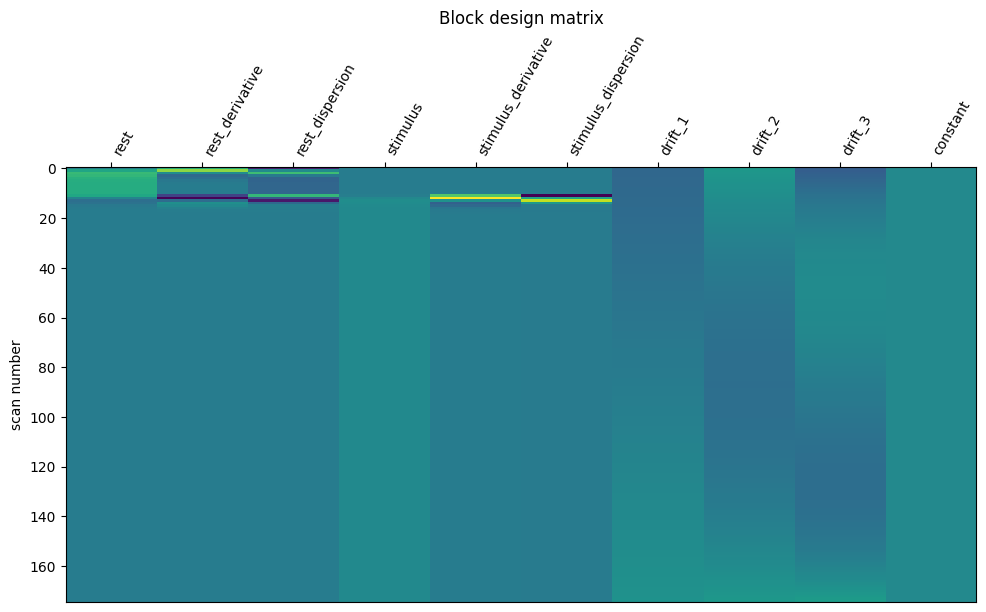

In [ ]:
# Test
image_paths, event_paths, anat = get_paths('/content/ds001246-download/',
                                           'perceptionTest01',
                                           'sub-03',
                                           4)
dm = create_design_matrices(event_paths)

fig, (ax1) = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
plot_design_matrix(dm[2], ax=ax1)
ax1.set_title('Block design matrix', fontsize=12)

In [ ]:
def create_contrasts(contrast, design_matrices):
  

  contrast_def = []
  for design_matrix in design_matrices:
      columns = list(design_matrix.columns)
      first_contrast_index = columns.index(contrast[0])
      second_contrast_index = columns.index(contrast[1])

      matrix_contrast = np.zeros((len(columns)))
      matrix_contrast[first_contrast_index] = 1
      matrix_contrast[second_contrast_index] = -1

      contrast_def.append(matrix_contrast)

  return contrast_def

In [ ]:
from nilearn.glm.first_level import FirstLevelModel



def glm_single_ses (dirpath, ses_name, sub, contrast, stat_type, nsample, resample=False, eoi):
  
    image_paths, event_paths, anat = get_paths(dirpath, ses_name, sub, nsample, resample=resample, events_of_interest=eoi)
    design_matrices = create_design_matrices(event_paths)

    fmri_glm = FirstLevelModel()
    fmri_glm = fmri_glm.fit(image_paths, design_matrices=design_matrices)

    contrast_def = create_contrasts(contrast, design_matrices)
    contrasts = fmri_glm.compute_contrast(contrast_def=contrast_def, output_type='all', stat_type=stat_type)

    return fmri_glm, contrasts, anat

fmri_glm, contrast, anat = glm_single_ses(dirpath = '/content/ds001246-download/',
                                          ses_name = 'perceptionTest + imageryTest',
                                          sub = 'sub-02',
                                          contrast = ['stimulus', 'imagery'],
                                          stat_type = 't',
                                          nsample = 15, 
                                          resample=False, 
                                          eoi='cue + imagery + stimulus')


In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img
from nilearn import image

def plot_contrast(contrast, stat_img, display_mode, resample=False, smoothing=None, bg_img=None):

    stat_img = contrast[stat_img]
    if resample == True:
        template = load_mni152_template(resolution=1)
        stat_img = resample_to_img(stat_img, template)
    if smoothing != None:
        mean_func = image.mean_img(stat_img)
        stat_img = image.smooth_img(mean_func, smoothing)

    plot_stat_map(stat_img, display_mode=display_mode, colorbar=True, black_bg=True, bg_img=bg_img)


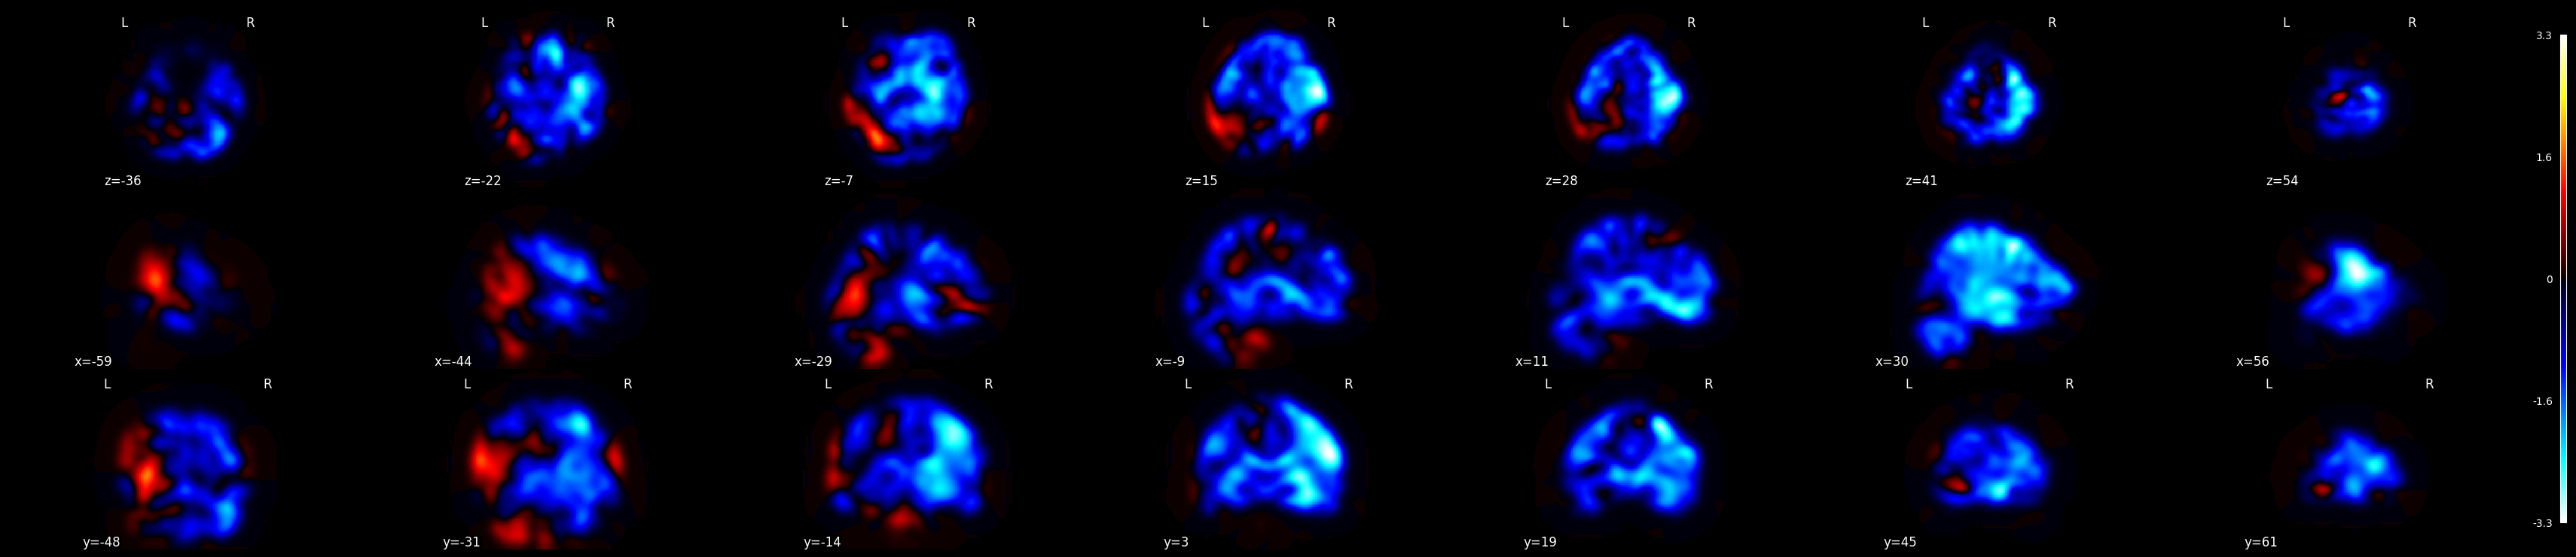

In [ ]:
plot_contrast(contrast = contrast,
              stat_img = 'z_score',
              display_mode = 'mosaic',
              resample = True,
              smoothing = 12)

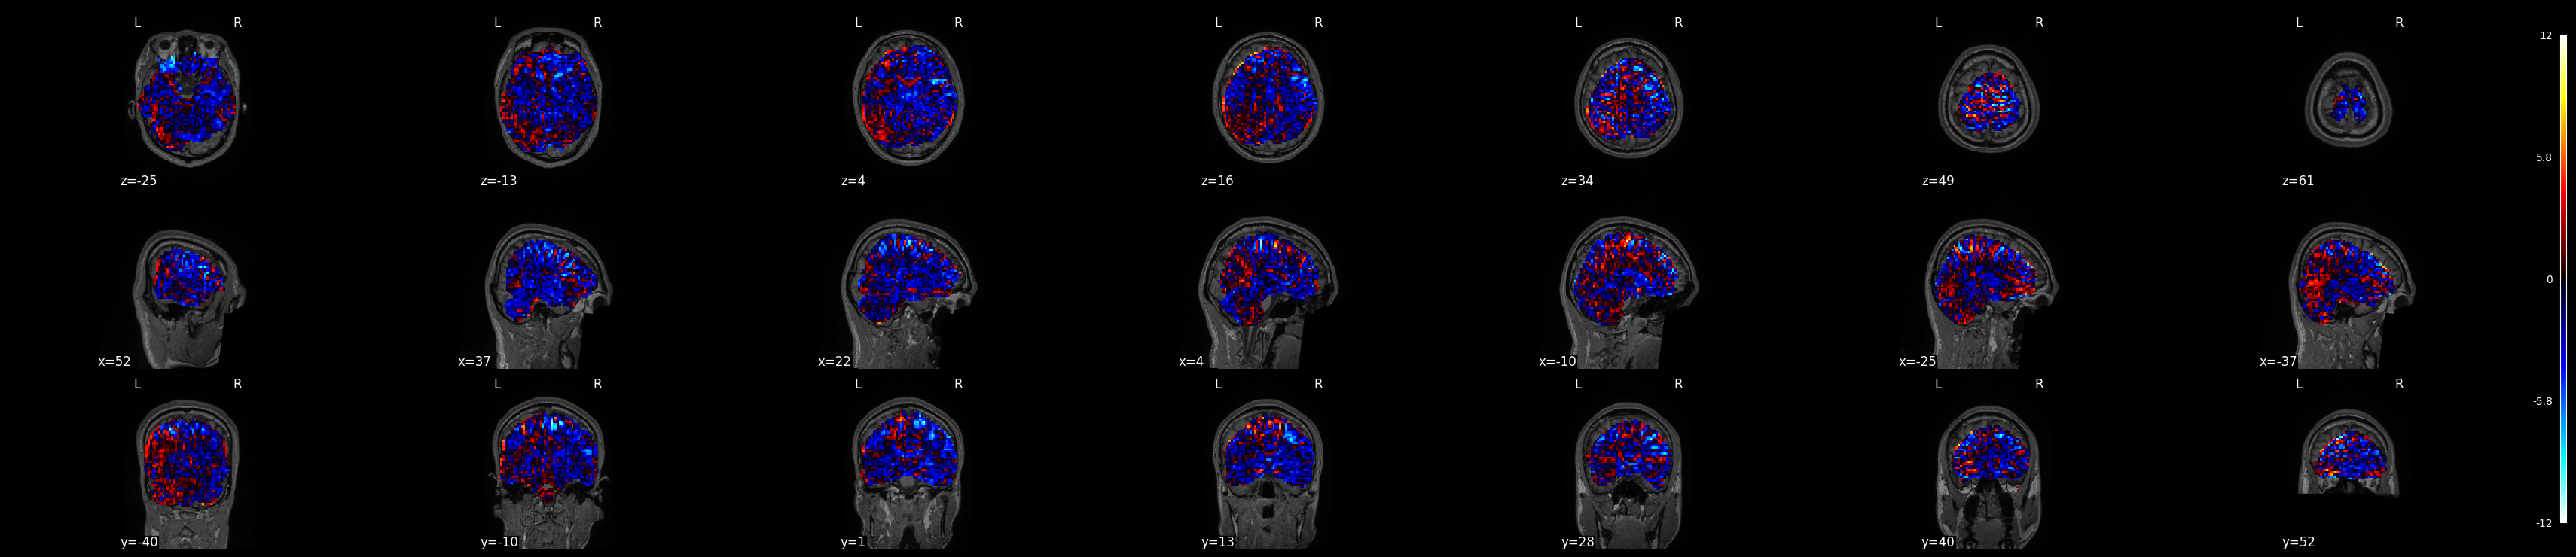

In [ ]:
plot_contrast(contrast=contrast,
              stat_img = 'z_score',
              display_mode = 'mosaic',
              resample=False,
              bg_img=anat)

In [ ]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import resample_to_img, load_img


atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
masker = NiftiLabelsMasker(atlas.maps,
                           labels=atlas.labels,
                           standardize=True)

atlas_img = load_img(atlas.filename)
resampled_stat = resample_to_img(contrast['z_score'], atlas_img)

In [ ]:
masker.fit_transform(contrast['z_score'])
report = masker.generate_report()
report

label value,region name,size (in mm^3),relative size (in %)
1,Frontal Pole,123176,11.75
2,Insular Cortex,18728,1.79
3,Superior Frontal Gyrus,40640,3.88
4,Middle Frontal Gyrus,42528,4.06
5,"Inferior Frontal Gyrus, pars triangularis",8824,0.84
6,"Inferior Frontal Gyrus, pars opercularis",11072,1.06
7,Precentral Gyrus,68584,6.54
8,Temporal Pole,37688,3.59
9,"Superior Temporal Gyrus, anterior division",4168,0.4
10,"Superior Temporal Gyrus, posterior division",14640,1.4


# Independent Component Analysis

In [ ]:
from nilearn.decomposition import CanICA

canica = CanICA(
    n_components=5,
    memory="nilearn_cache",
    memory_level=2,
    verbose=10,
    mask_strategy="epi",
    random_state=0,
    smoothing_fwhm=15
)
canica.fit(image_paths)
canica_components_img = canica.components_img_

[MultiNiftiMasker.fit] Loading data from [/content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-01_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-02_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-03_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-04_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-05_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-06_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-07_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   48.9s finished


[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-01_bold_preproc.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals


/usr/local/lib/python3.10/dist-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-02_bold_preproc.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-03_bold_preproc.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-04_bold_preproc.nii.gz')
[MultiNi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


__________________________________________________________fastica - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=398764591)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


__________________________________________________________fastica - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=924231285)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


__________________________________________________________fastica - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=1478610112)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


__________________________________________________________fastica - 4.8s, 0.1min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=441365315)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.0s remaining:    0.0s


__________________________________________________________fastica - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=1537364731)


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s


__________________________________________________________fastica - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=192771779)


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.8s remaining:    0.0s


__________________________________________________________fastica - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=1491434855)


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.3s remaining:    0.0s


__________________________________________________________fastica - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=1819583497)


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.7s remaining:    0.0s


__________________________________________________________fastica - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.decomposition._fastica.fastica...
fastica(array([[0.002557, ..., 0.003796],
       ...,
       [0.004758, ..., 0.004424]]), whiten='arbitrary-variance', fun='cube', random_state=530702035)


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.8s finished


__________________________________________________________fastica - 2.8s, 0.0min


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


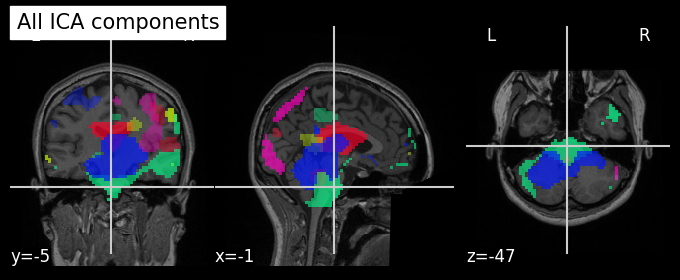

In [ ]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(canica_components_img,
                title="All ICA components",
                bg_img = anat)

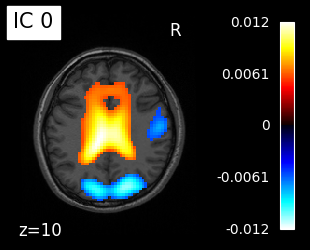

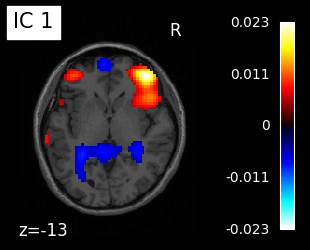

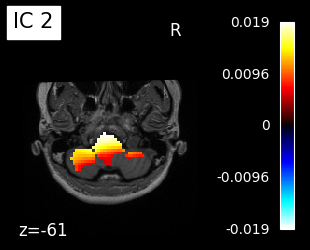

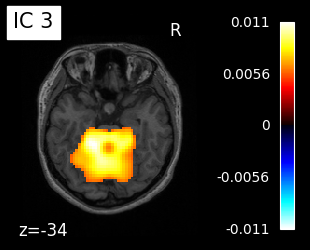

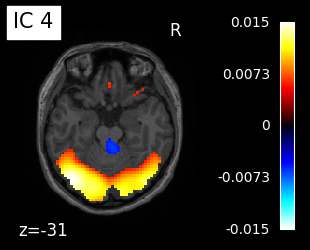

In [ ]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(canica_components_img)):
    plot_stat_map(
        cur_img,
        display_mode='z',
        title=f"IC {int(i)}",
        cut_coords=1,
        colorbar=True,
        bg_img=anat
    )

# Dictionary Learning 

In [ ]:
from nilearn.decomposition import DictLearning

dict_learning = DictLearning(
    n_components=5,
    memory="nilearn_cache",
    memory_level=2,
    verbose=1,
    random_state=0,
    n_epochs=20,
    mask_strategy="epi",
    smoothing_fwhm=15
)

dict_learning.fit(image_paths)
dictlearning_components_img = dict_learning.components_img_


[MultiNiftiMasker.fit] Loading data from [/content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-01_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-02_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-03_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-04_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-05_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-06_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-05_ses-perceptionimageryTest01_task-perceptionimagery_run-07_bold_preproc.nii.gz,
 /content/ds001246-download/combined/images/sub-0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)


____________________________________________dict_learning_online - 82.2s, 1.4min


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


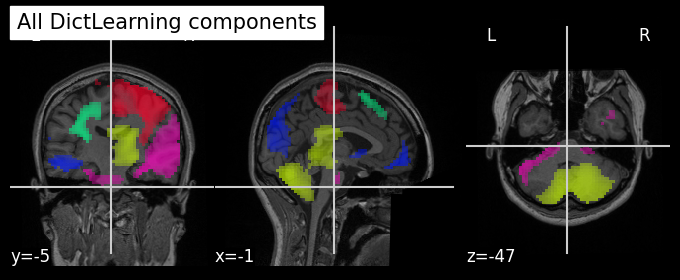

In [ ]:
plot_prob_atlas(dictlearning_components_img,
                title="All DictLearning components",
                bg_img = anat)

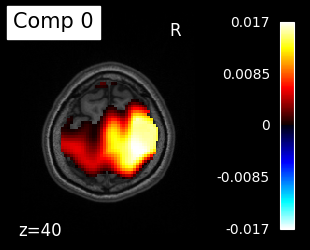

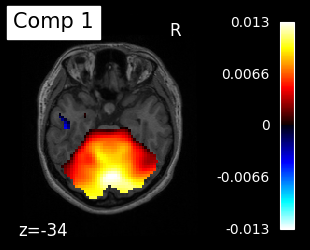

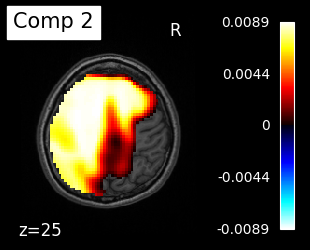

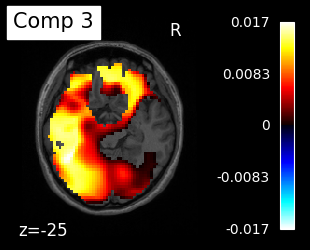

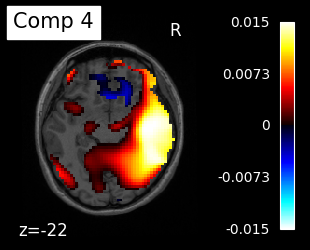

In [ ]:
for i, cur_img in enumerate(iter_img(dictlearning_components_img)):
    plot_stat_map(
        cur_img,
        display_mode="z",
        title=f"Comp {int(i)}",
        cut_coords=1,
        colorbar=True,
        bg_img=anat
    )

# Multi-Voxel Pattern Analysis

In [ ]:
image_paths, event_paths, anat = get_paths('/content/ds001246-download/',
                                           'imageryTest + perceptionTest ',
                                           'sub-05',
                                           nsamples=10, 
                                           events_of_interest='stimulus + imagery + cue') 

In [ ]:
from sklearn.utils import shuffle
import nibabel as nib
import numpy as np

resampled_training_events = resample_events(event_paths[:8], 3) # first three corresponds to training set and second for tr
final_training_events  = stack_events(resampled_training_events)
final_training_img = stack_images(image_paths[:8])  # three corresponds to training set 


np_image_train = np.array(final_training_img.dataobj)
image_affine = final_training_img.affine

random_permut = np.random.permutation(len(final_training_events))

training_labels, np_training_images = final_training_events.iloc[random_permut], np_image_train[:, :, :, random_permut]
nifti_training_images = nib.Nifti1Image(np_training_images, affine=image_affine)


In [ ]:
# clear RAM 

del np_image_train
del final_training_img
del np_training_images

In [ ]:
from nilearn.decoding import Decoder 
decoder = Decoder(estimator='svc',
                  cv=4,
                  mask_strategy='epi') 


decoder.fit(nifti_training_images, training_labels['event_type']) 

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


In [ ]:
y_pred = decoder.predict(nifti_training_images)
y_test = training_labels['event_type']

accuracy = (y_pred == y_test).mean() * 100.
print("\nsvm training classification accuracy : %g%%" % accuracy)

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)



svm training classification accuracy : 100%


In [ ]:
resampled_validation_events = resample_events(event_paths[10:], 3) 

validation_labels = stack_events(resampled_validation_events)
dev_images = stack_images(image_paths[10:]) 

y_pred_validation = decoder.predict(dev_images)
y_label_validation = validation_labels['event_type']

accuracy = (y_pred_validation == y_label_validation).mean() * 100.
print("\nsvm validation classification accuracy : %g%%" % accuracy)

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)



svm validation classification accuracy : 86.4762%


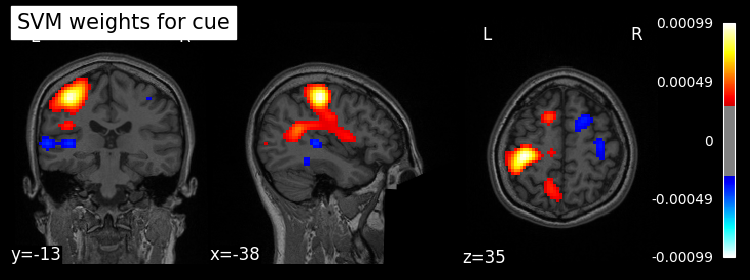

In [ ]:
from nilearn.plotting import plot_stat_map, show
from nilearn import image

weight_img = decoder.coef_img_["cue"]
mean_func = image.mean_img(weight_img)
stat_img = image.smooth_img(mean_func, 15)
plot_stat_map(stat_img,
              bg_img=anat,
              title="SVM weights for cue",
              threshold=0.0003,
              draw_cross=False)

show()

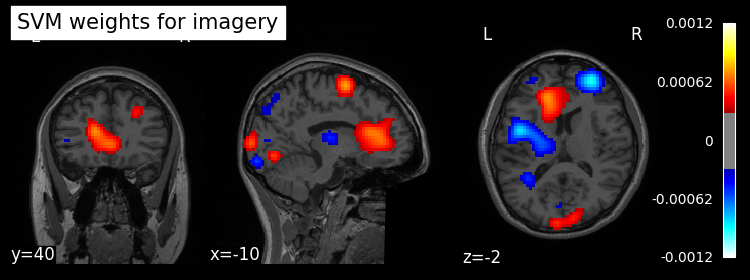

In [ ]:
from nilearn.plotting import plot_stat_map, show
from nilearn import image

weight_img = decoder.coef_img_["imagery"]
mean_func = image.mean_img(weight_img)
stat_img = image.smooth_img(mean_func, 15)
plot_stat_map(stat_img,
              bg_img=anat,
              title="SVM weights for imagery",
              threshold=0.0003,
              draw_cross=False)

show()

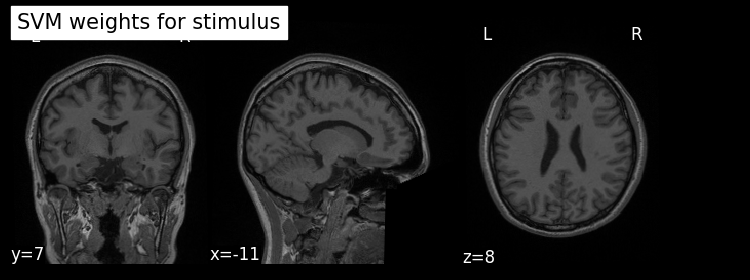

In [ ]:
weight_img = decoder.coef_img_["stimulus"]
mean_func = image.mean_img(weight_img)
stat_img = image.smooth_img(mean_func, 15)
plot_stat_map(stat_img,
              bg_img=anat,
              title="SVM weights for stimulus",
              threshold=0.0003,
              draw_cross=False)

show()

# SpaceNet

In [ ]:
from nilearn.decoding import SpaceNetClassifier
from nilearn.masking import compute_epi_mask

mask = compute_epi_mask(nifti_training_images)

decoder = SpaceNetClassifier(penalty='graph-net',
                             mask= mask,
                             max_iter=2,
                             t_r=3.0,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(nifti_training_images, training_labels['event_type'])

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask


In [ ]:
y_pred = decoder.predict(nifti_training_images)
y_test = training_labels['event_type']

accuracy = (y_pred == y_test).mean() * 100.
print("\nsvm training classification accuracy : %g%%" % accuracy)


graph-net  classification accuracy : 75.3247%


In [ ]:
resampled_validation_events = resample_events(event_paths[10:], 3) 

validation_labels = stack_events(resampled_validation_events)
dev_images = stack_images(image_paths[10:]) 

y_pred_validation = decoder.predict(dev_images)
y_label_validation = validation_labels['event_type']

accuracy = (y_pred_validation == y_label_validation).mean() * 100.
print("\nsvm validation classification accuracy : %g%%" % accuracy)

In [ ]:
from nilearn.plotting import plot_stat_map, show
from nilearn import image

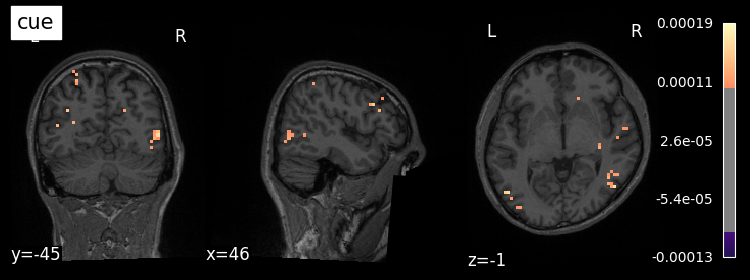

In [ ]:
i = 0
weight_img = decoder.coef_img_.slicer[:, :, :, i]
mean_func = image.mean_img(weight_img)
stat_img = image.smooth_img(mean_func, 15)
plot_stat_map(stat_img, black_bg=True, bg_img=anat, colorbar=True,
              display_mode='ortho', symmetric_cbar=False, threshold = 0.001,
              cmap='magma', title="{}".format(unique_events[i]), draw_cross= False)
show()

In [ ]:
i = 1
weight_img = decoder.coef_img_.slicer[:, :, :, i]
mean_func = image.mean_img(weight_img)
stat_img = image.smooth_img(mean_func, 15)
plot_stat_map(stat_img, black_bg=True, bg_img=anat, colorbar=True,
              display_mode='ortho', symmetric_cbar=False, threshold = 0.001,
              cmap='magma', title="{}".format(unique_events[i]), draw_cross= False)
show()

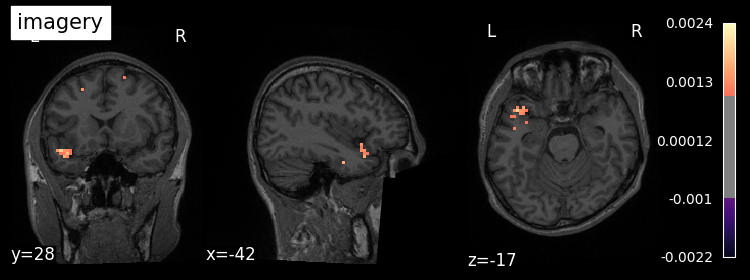

In [ ]:
i = 2
weight_img = decoder.coef_img_.slicer[:, :, :, i]
mean_func = image.mean_img(weight_img)
stat_img = image.smooth_img(mean_func, 15)
plot_stat_map(stat_img, black_bg=True, bg_img=anat, colorbar=True,
              display_mode='ortho', symmetric_cbar=False, threshold = 0.001,
              cmap='magma', title="{}".format(unique_events[i]), draw_cross= False)
show()

# Deep Neural Networks Analysis

**Here we load data**

In [14]:
image_paths, event_paths, anat = get_paths('/content/ds001246-download/',
                                           'imageryTest + perceptionTest ',
                                           'sub-05',
                                           nsamples=10, 
                                           events_of_interest='stimulus + imagery') 

In [15]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import nibabel as nib
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(image_paths, event_paths, test_size=0.1, random_state=42)

y_train = resample_events(y_train, tr=3) 
y_train  = stack_events(y_train)
X_train = stack_images(X_train)  

y_train = y_train.reset_index(drop=True)
print('X_train shape: \n', X_train.shape)
print('\n labels: \n', y_train.tail())
print('\n labels length: \n', len(y_train))

X_train shape: 
 (64, 64, 50, 2610)

 labels: 
      event_type  onset  duration
2605   stimulus   7815         3
2606   stimulus   7818         3
2607   stimulus   7821         3
2608   stimulus   7824         3
2609   stimulus   7827         3

 labels length: 
 2610


In [16]:
def ts_unsqueeze(image, labels, time_series):

    
    labels = labels.reset_index(drop=False)
    split_labels = [x for _, x in labels.groupby('event_type')]
    split_indices = [len(df) for df in split_labels][:-1]


    numpy_image = np.array(image.dataobj)
    image_affine = image.affine
    split_images = np.split(numpy_image, split_indices, axis=-1)

    ts_df = []
    ts_images = []
    for index, df in enumerate(split_labels):

        if df.iloc[0]['event_type'] == 'imagery':
            df = df.reset_index(drop=True)
            new_df = {'event_type':[], 'onset':[], 'duration':[]}
            new_df = pd.DataFrame(new_df)
            ts_img_list = []
            for i in range(0, len(df), 5):
                for j in range(time_series):
                    new_ts_label = [ df.iloc[i+j]['event_type'], df.iloc[i+j]['onset'], (df.iloc[i+j]['duration']*time_series)]
                    new_df.loc[len(new_df)] = new_ts_label
                    new_ts_img_slice = split_images[index][:, :, :, (i+j):(i+(j+time_series))]
                    ts_img_list.append(new_ts_img_slice)
            ts_images.append(np.stack(ts_img_list))        
            ts_df.append(new_df)

        elif df.iloc[0]['event_type'] == 'stimulus':
            df = df.reset_index(drop=True)
            new_df = {'event_type':[], 'onset':[], 'duration':[]}
            new_df = pd.DataFrame(new_df)
            ts_img_list = []
            for i in range(0, len(df), 3):
                new_ts_label = [ df.iloc[i]['event_type'], df.iloc[i]['onset'], (df.iloc[i]['duration']*time_series)]
                new_df.loc[len(new_df)] = new_ts_label
                new_ts_img_slice = split_images[index][:, :, :, i:(i+time_series)]
                ts_img_list.append(new_ts_img_slice)
            ts_images.append(np.stack(ts_img_list))        
            ts_df.append(new_df) 


    image = nib.Nifti1Image(np.transpose(np.vstack(ts_images), (0, -1, 3, 1, 2)), image_affine)
    labels = pd.concat(ts_df, ignore_index=True, axis=0)

    return image, labels         


X_train, y_train = ts_unsqueeze(X_train, y_train, time_series=3)
print('X_train shape: \n', X_train.shape)
print('\n labels: \n', y_train.tail())
print('\n labels length: \n', len(y_train))

X_train shape: 
 (1170, 3, 50, 64, 64)

 labels: 
      event_type  onset  duration
1165   stimulus   7785         9
1166   stimulus   7794         9
1167   stimulus   7803         9
1168   stimulus   7812         9
1169   stimulus   7821         9

 labels length: 
 1170


In [17]:
# here we shuffle scans for better training
X_train_data = np.array(X_train.dataobj)
X_train_affine = X_train.affine

random_permut = np.random.permutation(len(y_train))

y_train, X_train_data = y_train.iloc[random_permut], X_train_data[ random_permut, :, :, :, : ]
X_train = nib.Nifti1Image(X_train_data, affine=X_train_affine)

print('X_train shape: \n', X_train.shape)
print('\n labels: \n', y_train.head())
print('\n labels length: \n', len(y_train))

X_train shape: 
 (1170, 3, 50, 64, 64)

 labels: 
     event_type  onset  duration
844   stimulus   3021         9
532    imagery   6123         9
882   stimulus   3363         9
821   stimulus   2439         9
445    imagery   4698         9

 labels length: 
 1170


In [18]:
import torch
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.functional import one_hot

In [19]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': torch.from_numpy(image),
                'label': one_hot(torch.from_numpy(np.asarray(label)), num_classes=2)}

In [20]:
class Dataset():

    def __init__(self, X, y, transform=None):
        
        self.X = np.array(X)
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.X[idx, :, :, :, :]
        label = np.squeeze(self.y[idx])
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train['event_type'].values)
dataset = Dataset(X= X_train.dataobj, y=y_train, transform=ToTensor())

In [21]:
batch_size = 1
dev_split = .1
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split_dev = int( np.floor(dev_split * dataset_size))


if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
dev_indices = indices[:split_dev]
train_indices = indices[split_dev:]


train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(dev_indices)

In [22]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [23]:
from torch import nn
from torchvision import models
import torch.nn.functional as F



class SubUnet_orig(nn.Module):
    def __init__(self,hidden_size,n_layers,dropt,bi,N_classes):
        super(SubUnet_orig, self).__init__()

        self.hidden_size=hidden_size
        self.num_layers=n_layers

        self.dim_feats = 32
  
        self.conv1 = nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=0)
        self.conv1_In = nn.InstanceNorm3d(8)

        self.conv2 = nn.Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=0)
        self.conv2_In = nn.InstanceNorm3d(32)

        self.conv3 = nn.Conv3d(32, 128, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=0)
        self.conv3_In = nn.InstanceNorm3d(128)
        
        self.conv4 = nn.Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=0)
        self.conv4_In = nn.InstanceNorm3d(64)

        self.conv5 = nn.Conv3d(64, 16, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=0)
        self.conv5_In = nn.InstanceNorm3d(16)

        self.conv6 = nn.Conv3d(16, 2, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=0)
        self.conv6_In = nn.InstanceNorm3d(2)

        self.lstm = nn.LSTM(
            input_size=self.dim_feats,
            hidden_size=self.hidden_size,
            bias = True,
            num_layers=self.num_layers,
            dropout=dropt,
            bidirectional=True, 
            batch_first=True)
        

        self.n_cl=N_classes
        self.softmax = nn.Softmax()
        self.Leaky_ReLU = nn.LeakyReLU()
        self.last_linear = nn.Linear(2*self.hidden_size, 32)
        self.last_linear_1 = nn.Linear(32, 16)
        self.last_linear_2 = nn.Linear(16, 8)
        self.last_linear_3 = nn.Linear(8, self.n_cl)

        
            

    def forward(self, x):

        batch_size, timesteps, C,H, W = x.size()
        c_in = x.view(batch_size, timesteps , C, H, W)
        hidden = None
        for t in range(c_in.size(1)):
              x = self.Leaky_ReLU(self.conv1_In(self.conv1(c_in[:, t, :, :, :])))
              x = self.Leaky_ReLU(self.conv2_In(self.conv2(x)))
              x = self.Leaky_ReLU(self.conv3_In(self.conv3(x)))
              x = self.Leaky_ReLU(self.conv4_In(self.conv4(x)))
              x = self.Leaky_ReLU(self.conv5_In(self.conv5(x)))
              x = self.Leaky_ReLU(self.conv6_In(self.conv6(x)))
              x = torch.flatten(x, start_dim=1) 
              out, hidden = self.lstm(x.unsqueeze(0), hidden) 
        
        fc_out = self.Leaky_ReLU(self.last_linear(out[-1, :, :]))
        fc_out = self.Leaky_ReLU(self.last_linear_1(fc_out))
        fc_out = self.Leaky_ReLU(self.last_linear_2(fc_out))
        fc_out = self.last_linear_3(fc_out)
        fc_out = torch.sum(fc_out, 1)
        fc_out = self.softmax(fc_out)


        return fc_out

In [24]:
net = SubUnet_orig(hidden_size=64, n_layers=3, dropt=0, bi=True, N_classes=2 )

In [25]:
import torch.optim as optim

criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adamax(net.parameters(), weight_decay=0.0001, lr=0.0001)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

SubUnet_orig(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv1_In): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv3d(8, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv2_In): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv3d(32, 128, kernel_size=(5, 5, 5), stride=(2, 2, 2))
  (conv3_In): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv4): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv4_In): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv5): Conv3d(64, 16, kernel_size=(5, 5, 5), stride=(2, 2, 2))
  (conv5_In): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv6): Conv3d(16, 2, kernel_size=(5, 5, 5), stride=(2, 2, 2))
  (conv6_In): InstanceNorm3d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=

In [27]:
def partition_assign(a, n):
    idx = np.argpartition(a,-n,axis=0)[-n:]
    out = np.zeros(a.shape, dtype=int)
    np.put_along_axis(out,idx,1,axis=0)
    return torch.from_numpy(out)

In [ ]:
from tqdm import tqdm
from time import sleep

for epoch in range(100):  # loop over the dataset multiple times

    corrects = 0
    running_loss = 0.0
    accuracy = 0.0
    for param in net.parameters():
      param.requires_grad = True
    net.train()
    with tqdm(train_loader, unit="batch") as tepoch:
      for i, data in enumerate(tepoch, 0):
          # get the inputs; data is a list of [inputs, labels]
          
          tepoch.set_description(f"Epoch {epoch}")

          inputs, labels = data['image'].type(torch.float32), data['label'].type(torch.float32).squeeze(0)
          inputs, labels = inputs.to(device), labels.to(device)



          # zero the parameter gradients
          optimizer.zero_grad()

          
          # forward + backward + optimize
          outputs = net(inputs)
          

          loss = criterion(outputs.cuda(), labels.cuda())

          
          loss.backward()
          optimizer.step()

          

          # print statistics
          prediction = partition_assign(outputs.cpu().detach().numpy(), n=1)
          corrects += torch.eq(prediction.to(device), labels).sum() / 2

          running_loss += loss.item()

    print('training accuracy: ', np.array((corrects/ len(train_loader)).cpu())*100)
    print('training loss: ', np.array((running_loss / len(train_loader))))
    # ############ Validation  ################
    corrects = 0
    running_loss = 0.0
    accuracy = 0.0
    net.eval()
    with tqdm(valid_loader, unit="batch") as tepoch:
      for i, data in enumerate(tepoch, 0):
          # get the inputs; data is a list of [inputs, labels]
          
          tepoch.set_description(f"Validation {epoch}")

          inputs, labels = data['image'].type(torch.float32), data['label'].type(torch.float32)
          inputs, labels = inputs.to(device), labels.to(device)
          
          with torch.no_grad():

            outputs = net(inputs)

          
          prediction = partition_assign(outputs.cpu().detach().numpy(), n=1)
          corrects += torch.eq(prediction.to(device), labels).sum() / 2
          
          running_loss += loss.item()

      print('validation accuracy: ', np.array((corrects/ len(valid_loader)).cpu())*100)
      print('validation loss: ', np.array((running_loss / len(valid_loader)))) 

    # torch.save(net.state_dict(), '/content/drive/MyDrive/Generic Decoding model weights/model_weights_epoch_{}_valloss_{}.pth'.format(epoch, valloss))

print('Finished Training')

Epoch 0:   0%|          | 0/1053 [00:00<?, ?batch/s]<ipython-input-23-9bacf0ba1dd2>:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  fc_out = self.softmax(fc_out)
Epoch 0: 100%|██████████| 1053/1053 [02:12<00:00,  7.94batch/s]


training accuracy:  56.98005557060242
training loss:  0.6931345965447928


Validation 0: 100%|██████████| 117/117 [00:03<00:00, 33.70batch/s]


validation accuracy:  0.8547008968889713
validation loss:  0.6930870413780212


Epoch 1: 100%|██████████| 1053/1053 [02:11<00:00,  8.02batch/s]


training accuracy:  57.16999173164368
training loss:  0.6931434003715842


Validation 1: 100%|██████████| 117/117 [00:03<00:00, 34.28batch/s]


validation accuracy:  0.0
validation loss:  0.6931564807891846


Epoch 2: 100%|██████████| 1053/1053 [02:12<00:00,  7.92batch/s]


training accuracy:  57.16999173164368
training loss:  0.693146461435193


Validation 2: 100%|██████████| 117/117 [00:03<00:00, 32.50batch/s]


validation accuracy:  0.8547008968889713
validation loss:  0.6931488513946533


Epoch 3: 100%|██████████| 1053/1053 [02:08<00:00,  8.20batch/s]


training accuracy:  57.16999173164368
training loss:  0.6931471397847305


Validation 3: 100%|██████████| 117/117 [00:03<00:00, 33.49batch/s]


validation accuracy:  0.0
validation loss:  0.6931473016738892


Epoch 4:  99%|█████████▉| 1047/1053 [02:00<00:00,  8.94batch/s]

In [ ]:
y_test= resample_events(y_test, tr=3) 
y_test = stack_events(y_test)
X_test = stack_images(X_test)  

y_test = y_test.reset_index(drop=True)
X_test, y_test = ts_unsqueeze(X_test, y_test, time_series=3)

y_test = encoder.fit_transform(y_test['event_type'].values)
dataset_test = Dataset(X= X_test.dataobj, y=y_test, transform=ToTensor())

test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [ ]:
corrects = 0
running_loss = 0.0
accuracy = 0.0
net.eval()

output_list = []
label_list = []
with tqdm(test_loader, unit="batch") as tepoch:
      for i, data in enumerate(tepoch, 0):
          tepoch.set_description(f"test {epoch}")

          inputs, labels = data['image'].type(torch.float32), data['label'].type(torch.float32)
          inputs, labels = inputs.to(device), labels.to(device)
          
          with torch.no_grad():

            outputs = net(inputs)

          output_list.append(outputs)
          label_list.append(labels)

          prediction = partition_assign(outputs.cpu().detach().numpy(), n=1)
          corrects = torch.eq(prediction.to(device), labels).sum() / 2
          running_loss += loss.item()
          accuracy += np.array( (corrects / labels.shape[0]).cpu() )
      testloss = np.array(running_loss) / len(test_loader) 
      print('testset Accuracy: ', (accuracy/len(test_loader)))
      print("testset Loss: ", testloss)


test 99:   0%|          | 0/130 [00:00<?, ?batch/s]<ipython-input-131-a8b81efbbe7a>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  fc_out = self.softmax(fc_out)
test 99: 100%|██████████| 130/130 [00:03<00:00, 33.50batch/s]

testset Accuracy:  1.0
testset Loss:  0.33303794264793396


In [ ]:
for i in range(len(output_list)):

    print(output_list[i])
    print(label_list[i])
    print('\n\n\n')

tensor([0.1432, 0.8568], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')




tensor([0.1494, 0.8506], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')




tensor([0.9609, 0.0391], device='cuda:0')
tensor([[1., 0.]], device='cuda:0')




tensor([0.1049, 0.8951], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')




tensor([0.1895, 0.8105], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')




tensor([0.9607, 0.0393], device='cuda:0')
tensor([[1., 0.]], device='cuda:0')




tensor([0.9608, 0.0392], device='cuda:0')
tensor([[1., 0.]], device='cuda:0')




tensor([0.9496, 0.0504], device='cuda:0')
tensor([[1., 0.]], device='cuda:0')




tensor([0.9597, 0.0403], device='cuda:0')
tensor([[1., 0.]], device='cuda:0')




tensor([0.1187, 0.8813], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')




tensor([0.9598, 0.0402], device='cuda:0')
tensor([[1., 0.]], device='cuda:0')




tensor([0.1466, 0.8534], device='cuda:0')
tensor([[0., 1.]], device='cuda:0')




tensor([0.1336, 